# Uppdatering av data
*ddf--sodertornsmodellen*

Uppdatering av Geografiska Informationsbyrån, januari 2019

## Utgångsläge

https://open-numbers.github.io/sodertornsmodellen/ ska uppdateras med nya data.

De data som visas i verktyget idag (början av januari 2019) ligger i det här repot [ddf--sodertornsmodellen](https://github.com/open-numbers/ddf--sodertornsmodellen/)

## Struktur

Indata på basområdesnivå från SCB får inte distribueras fritt. Nedanstående filstruktur används därför för att hålla indata separat från script och utdata.

```
.
├── ddf--sodertornsmodellen-output (git-repo)
├── indata
│   ├── ddf--sodertornsmodellen
│   ├── MASTER_00-17.xlsx
│   ├── ODB_TSV
│   └── supermappen
├── notebooks (git-repo)
└── sodertornsmodellen (git-repo)

```

### ddf--sodertornsmodellen-output

Git repot med uppdaterade ddf-csv filer. Hålls separat från originalrepot för att undvika problem med att läsa och skriva till samma fil. Det skapar problem när scripten körs mer än en gång.

### indata

Det finns fyra indatakällor.

1. De data som redan ligger i verktyget [ddf--sodertornsmodellen](https://github.com/open-numbers/ddf--sodertornsmodellen/). Dels datapoints `*datapoints*.csv` filerna

1. Excelfilen `MASTER_00-17.csv.xlsx`

1. `.csv` filterna i `Supermappen`

1. `.txt` tsv exporter från ODB

### gib-update

Jupyter notebooks och python-script för vår uppdatering.

### sodertornsmodellen

För att kunna testa att uppdateringarna fungerar allt eftersom har vi lagt upp en kopia av verktyget på https://geografiskainformationsbyran.se/sodertornsmodellen/






----

----

----

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
indataPath = os.path.join(os.pardir, "indata")

ddfRootPath = os.path.join(indataPath, "ddf--sodertornsmodellen")
ddfSrcPath = os.path.join(ddfRootPath, "ddf--sodertornsmodellen--src")

superPath = os.path.join(indataPath, "supermappen")

ddfOutputPath = os.path.join(os.pardir, 'ddf--sodertornsmodellen-output', 'ddf--sodertornsmodellen--src')

## Helpers

In [3]:
from helpers import *

----

----

----

## Läs in MASTER excel filen

In [4]:
master = pd.read_excel(os.path.join(indataPath, 'MASTER_00-17.xlsx'))

In [5]:
# byt namn på kolumner för att matcha namnen i ddf-filerna
master = master.rename(columns={
    'område': 'name',
    'Basområde': 'BASKODER', # kolumnen Basområde blandar BK2010 och BK2000
    'tid': 'year'
})

master['year'] = pd.to_datetime(master['year'].astype(str))

----

----

----

## Lookups

### Baskod2010 => Baskod2000

In [6]:
baskodkey = pd.read_excel(os.path.join(ddfRootPath, 'etl', 'source', '161115 A7 utan formler.xlsx'), skiprows=[0,1,2,3,4,5,6], converters={2010: lambda x: str(x)})
baskodkey = baskodkey[[2010, 'BASKOD2000']]
baskodkey = baskodkey.rename(columns={2010: 'BASKOD2010'})
baskodkey['BASKOD2010'] = baskodkey['BASKOD2010'].astype(str).astype(int)

In [7]:
baskodkey.head(5)

,BASKOD2010,BASKOD2000
0,1010110,1010110
1,1010120,1010120
2,1010130,1010130
3,1010140,1010140
4,1010201,1010201


In [8]:
print(baskodkey.shape[0])
print(baskodkey['BASKOD2010'].nunique())
print(baskodkey['BASKOD2000'].nunique())

1364
1364
1299


### Baskod2000 => Basomr entity name 

In [9]:
entityKey = pd.read_csv(os.path.join(ddfOutputPath, 'ddf--entities--basomrade.csv'))
entityKey = entityKey.rename(columns={'baskod2000': 'BASKOD2000'})
entityKey['basomrade'] = entityKey['basomrade'].astype(str)

entityKey = entityKey[['basomrade', 'BASKOD2000']]
# entityKey

In [10]:
entityKey.nunique()

basomrade     1086
BASKOD2000    1086
dtype: int64

----

----

----

# Lista kolumner i masterfilen

In [11]:
mas2014 = master[master['year'] >= pd.to_datetime('2014')]
mas2014 = mas2014.rename(columns = {
    'BASKODER': 'BASKOD2010'
})

In [12]:
masterCols = mas2014.columns.values[5:-2]#.tolist()
len(masterCols)
masterCols

array(['Befolkning Män', 'Befolkning Kvinnor', 'Befolkning Total',
       'Befolkning män18-64', 'Befolkning kvinnor 18-64',
       'Befolkning totalt 18-64', 'Befolkning män 16-',
       'Befolkning kvinnor 16-', 'Befolkning tot 16-', 'Lght_Hyresrätt',
       'Lght_Bostadsrätt', 'Lght_Äganderätt', 'Lght_Uppgift saknas',
       'Lght total', 'Lght_Andel_Hyresrätter', 'Lght_Andel_Bostadsrätter',
       'Lght_Andel_Äganderätter', 'Lght_Andel_Uppgift Sanas',
       'Fst_Lantbruksfastighet', 'Fst_Småhus inklusive Fritidshus',
       'Fst_Hyreshus', 'Fst_Övriga', 'Fst_Totalt',
       'Fst_Andel_Lantbruksfastighet',
       'Fst_Andel_Småhus inklusive Fritidshus', 'Fst_Andel_Hyreshus',
       'Fst_Andel_Övriga', 'Antal hushåll med barn',
       'Antal hushåll utan barn', 'Hsh_Gifta/sambo med barn',
       'Hsh_Gifta/sambo utan barn', 'Hsh_Ensamstående med barn',
       'Hsh_Ensamstående utan barn', 'Hsh_Övriga', 'Hsh_Total',
       'Hsh_Andel_Gifta/sambo med barn',
       'Hsh_Andel_Gifta/sam

In [13]:
for col in  masterCols:
    coldf = mas2014[['BASKOD2010', 'year', col]]
    coldf = pd.merge(coldf, baskodkey, on='BASKOD2010', how='left')
    coldf = pd.merge(coldf, entityKey[['BASKOD2000', 'basomrade']], on='BASKOD2000', how='left')
    coldf = coldf.dropna(how='any')
#     print(coldf)
#     print(master[['BASKODER', col]])

----

----

----

# Utbildningsnivå

Utbildningsnivå processas i en separat notebook: [educational_level](educational_level.ipynb)

----

----

----

# Befolkning 25-64

Processas i en separat notebook: [population_25_64](population_25_64.ipynb)

----

----

----

# Sysselsättning

Processas i en separat notebook: [employed](employed.ipynb)

----

----

----

# Medelinkomst

### Per kön

In [14]:
medelkon = glob.glob('../indata/supermappen/*MedelkonBas*.csv')

In [15]:
def readMedelkonBas(file):
    df = pd.read_csv(file, encoding='latin1' , sep=';', decimal=',', header=1)
    df['year'] = pd.to_datetime(getYear(file))
    df = df.rename(columns={
        "M=1 Kv = 2":'Kön',
        'Basområde': 'BASKOD2010',
        'inkl 0': 'mean_income'
    })
    df['Kön'] = df['Kön'].astype('category')
    df['Kön'].cat.categories = ['male', 'female']
    df['year'] = df['year'].apply(lambda t: t.year)
    return df

In [16]:
medelkondf = pd.concat(list(map(readMedelkonBas, medelkon)))

In [17]:
medelkondf = pd.merge(medelkondf, baskodkey, on='BASKOD2010', how='left')

In [18]:
medelkondf = pd.merge(medelkondf, entityKey[['BASKOD2000', 'basomrade']], on='BASKOD2000', how='left')

In [19]:
medelkondf = medelkondf.dropna(how='any')

In [20]:
medelkondf = medelkondf[['basomrade', 'year', 'mean_income','Kön']]

Saved mean_income_aged_gt_20_male to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--mean_income_aged_gt_20_male--by--basomrade--year.csv

Saved mean_income_aged_gt_20_female to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--mean_income_aged_gt_20_female--by--basomrade--year.csv



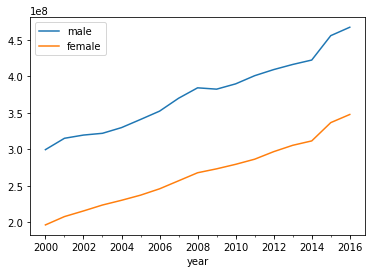

In [58]:
genders = medelkondf['Kön'].cat.categories.tolist()

for gender in genders:
    concept = 'mean_income_aged_gt_20_{gender}'.format(gender=gender)
    medel = medelkondf[medelkondf['Kön'] == gender]
    medel = medel[['basomrade', 'year', 'mean_income']]
    medel = medel.rename(columns = {'mean_income': 'value'})
    
    combined = appendNewDatapoints(concept, medel)
    plotcombined(combined, gender)
    

### Total

In [33]:
medel = glob.glob('../indata/supermappen/*MedelBas*.csv')

In [34]:
concept = 'mean_income_aged_gt_20'

In [35]:
def readMedel(file):
    df = pd.read_csv(file, encoding='latin1' , sep=';', decimal=',')
    df['year'] = pd.to_datetime(getYear(file))
    df = df.rename(columns={
        'basomrade': 'BASKOD2010',
        'Medel': 'value'
    })
    df['year'] = df['year'].apply(lambda t: t.year)
    return df

In [36]:
medeldf = pd.concat(list(map(readMedel, medel)))

In [37]:
medeldf = pd.merge(medeldf, baskodkey, on='BASKOD2010', how='left')

In [38]:
medeldf = pd.merge(medeldf, entityKey[['BASKOD2000', 'basomrade']], on='BASKOD2000', how='left')

In [39]:
medeldf = medeldf.dropna(how='any')

In [40]:
medeldf = medeldf[['basomrade', 'year', 'value']]
# medeldf = medeldf.rename(columns={conecpt: 'value'})

Saved mean_income_aged_gt_20_female to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--mean_income_aged_gt_20_female--by--basomrade--year.csv



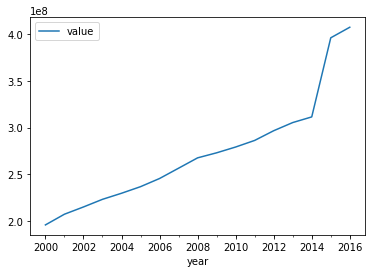

In [59]:
combined = appendNewDatapoints(concept, medeldf)
plotcombined(combined)

----

----

----

# Upplåtelseform bostäder

## Kombinera `.csv` med MASTER 

In [42]:
csv = pd.read_csv('../indata/supermappen/Tabell2A_FB7bas.csv', encoding='latin1' , sep=';', decimal=',')
csv['year'] = pd.to_datetime('2017')
csv = csv.rename(columns={
    "Basomrade": "BASKOD2010",
    "Hyresrätt": "antal_hyres",
    "Bostadsrätt": "antal_bostadsr",
    "Äganderätt": "antal_aegender",
    "Uppgift_saknas": "Lght_Uppgift saknas",
    "TOTALT": "Lght total"
})

subsetmas = master[['BASKODER','year', 'Lght_Hyresrätt', 'Lght_Bostadsrätt','Lght_Äganderätt','Lght_Uppgift saknas','Lght total']]
subsetmas = subsetmas.rename(columns = {
    "Lght_Hyresrätt": "antal_hyres",
    "Lght_Bostadsrätt": "antal_bostadsr",
    "Lght_Äganderätt": "antal_aegender"
})

In [43]:
mas2012 = subsetmas[subsetmas['year'] >= pd.to_datetime('2012')]
mas2012 = mas2012.rename(columns = {
    'BASKODER': 'BASKOD2010'
})

In [44]:
concat = pd.concat([csv, mas2012], sort=False)

## Summera efter år och Basområde2000 kod

In [45]:
# join the dataframe with the baskod2010 => baskod2000 key dataframe
merged = pd.merge(concat, baskodkey, on='BASKOD2010', how='left')

In [46]:
merged = pd.merge(merged, entityKey[['BASKOD2000', 'basomrade']], on='BASKOD2000', how='left')

In [47]:
# sidospår: de här basområdena saknas helt i entitiesfilen
notinc = merged[merged['basomrade'].isnull()].groupby('BASKOD2000').sum().reset_index()[['BASKOD2000', 'BASKOD2010']]
notinc['notinc'] = True
# notinc.to_csv('notincluded.csv', index=False)

In [48]:
# sum values by year and baskod2000
subset = merged[['year','BASKOD2000', 'basomrade', 'antal_hyres', 'antal_bostadsr', 'antal_aegender', 'Lght total']]
summed = pd.DataFrame(subset.groupby(['year','basomrade']).sum()).reset_index()

In [49]:
summed['year'] = summed['year'].apply(lambda t: t.year)

In [50]:
# ta bort rader som saknar data
summed = summed.dropna(how='any')

In [51]:
summed[['year', 'Lght total']].groupby('year').sum()

,Lght total
year,
2012,943331.0
2013,950892.0
2014,959773.0
2015,971836.0
2016,990371.0
2017,1028961.0


## Räkna andelar och exportera

#### Andel hyresrätter

In [52]:
summed['andel_hyres'] = summed['antal_hyres'] / summed['Lght total']
summed['andel_hyres'] = summed['andel_hyres'].round(4)
summed['andel_hyres'] = summed['andel_hyres'].astype(str).replace('0.0', '0')
summed['andel_hyres'] = summed['andel_hyres'].astype(str).replace('1.0', '1')
summed['andel_hyres'] = summed['andel_hyres'].astype(str).replace('nan', '')

In [53]:
summed[['basomrade', 'year', 'andel_hyres']].to_csv(os.path.join(ddfOutputPath, 'ddf--datapoints--andel_hyres--by--basomrade--year.csv'), index=False)

#### Andel bostadsrätter

In [54]:
summed['andel_bostadsr'] = summed['antal_bostadsr'] / summed['Lght total']
summed['andel_bostadsr'] = summed['andel_bostadsr'].round(4)
summed['andel_bostadsr'] = summed['andel_bostadsr'].astype(str).replace('0.0', '0')
summed['andel_bostadsr'] = summed['andel_bostadsr'].astype(str).replace('1.0', '1')
summed['andel_bostadsr'] = summed['andel_bostadsr'].astype(str).replace('nan', '')

In [55]:
summed[['basomrade', 'year', 'andel_bostadsr']].to_csv(os.path.join(ddfOutputPath, 'ddf--datapoints--andel_bostadsr--by--basomrade--year.csv'), index=False)

#### Andel äganderätter

In [56]:
summed['andel_aegender'] = summed['antal_aegender'] / summed['Lght total']
summed['andel_aegender'] = summed['andel_aegender'].round(4)
summed['andel_aegender'] = summed['andel_aegender'].astype(str).replace('0.0', '0')
summed['andel_aegender'] = summed['andel_aegender'].astype(str).replace('1.0', '1')
summed['andel_aegender'] = summed['andel_aegender'].astype(str).replace('nan', '')

In [57]:
summed[['basomrade', 'year', 'andel_aegender']].to_csv(os.path.join(ddfOutputPath, 'ddf--datapoints--andel_aegender--by--basomrade--year.csv'), index=False)

----